# OC IML - P7 - 01 : Retrieval based chatbot (baseline)

This notebook is used to build the retrieval-based chatbot used as an existing baseline in this project.


## Notebook settings

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
!pip install livelossplot
!pip install datasets

In [123]:
PATHS = {
    'data_dir': '/content/drive/MyDrive/Colab Notebooks/OC_IML/OC_IML_P7_POC/P7_03_data/',
    'output_dir': '/content/drive/MyDrive/Colab Notebooks/OC_IML/OC_IML_P7_POC/P7_03_data/models',
    'data_file': 'final_data.json',
    'vectorizer-binarizer': 'vectorizer-binarizer.pkl',
    'df_responses': 'responses.pkl',
    'model': '.h5',
}

## Import packages

In [111]:
import json, os
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

import joblib
import nltk
import tensorflow as tf
from nltk.stem import lancaster, WordNetLemmatizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import callbacks
from livelossplot import PlotLossesKeras

nltk.download('stopwords')
nltk.download('wordnet')

pd.set_option('display.width', -1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data preparation

[COVID-QA](https://huggingface.co/datasets/covid_qa_deepset) is a Question Answering dataset consisting of 2,019 question/answer pairs annotated by volunteer biomedical experts on scientific articles related to COVID-19. A total of 147 scientific articles from the CORD-19 dataset were annotated by 15 experts.  
- **question**: Query question
- **context**: Context text to obtain the answer from
- **document_id**: The document ID of the context text
- **answer**: Dictionary containing the answer string and the start index


In [112]:
dataset = load_dataset('covid_qa_deepset')
dataset

Reusing dataset covid_qa_deepset (/root/.cache/huggingface/datasets/covid_qa_deepset/covid_qa_deepset/1.0.0/fb886523842e312176f92ec8e01e77a08fa15a694f5741af6fc42796ee9c8c46)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['document_id', 'context', 'question', 'is_impossible', 'id', 'answers'],
        num_rows: 2019
    })
})

In [113]:
df = pd.DataFrame(dataset['train'], columns=['id', 'document_id', 'context', 'question', 'answers', 'is_impossible'])
df.head()

,id,document_id,context,question,answers,is_impossible
0,262,630,Functional Genetic Variants in DC-SIGNR Are As...,What is the main cause of HIV-1 infection in c...,{'text': ['Mother-to-child transmission (MTCT)...,False
1,276,630,Functional Genetic Variants in DC-SIGNR Are As...,What plays the crucial role in the Mother to C...,{'text': ['DC-SIGNR plays a crucial role in MT...,False
2,278,630,Functional Genetic Variants in DC-SIGNR Are As...,How many children were infected by HIV-1 in 20...,"{'text': ['more than 400,000 children were inf...",False
3,316,630,Functional Genetic Variants in DC-SIGNR Are As...,What is the role of C-C Motif Chemokine Ligand...,"{'text': ['High copy numbers of CCL3L1, a pote...",False
4,305,630,Functional Genetic Variants in DC-SIGNR Are As...,What is DC-GENR and where is it expressed?,{'text': ['Dendritic cell-specific ICAM-grabbi...,False


In [114]:
# extracting answers text
#   the 'text' values are lists and I don't knwow if they contains more than 1 item 
#   so I use '\n'.join() to be sure
df['answers'] = df['answers'].apply(lambda x: '\n'.join(x['text']))

In [115]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique items", end=' ')
    print(f"/ {df[df[col].duplicated()].shape[0]} duplicated items")

id: 2019 unique items / 0 duplicated items
document_id: 147 unique items / 1872 duplicated items
context: 147 unique items / 1872 duplicated items
question: 1973 unique items / 46 duplicated items
answers: 1990 unique items / 29 duplicated items
is_impossible: 1 unique items / 2018 duplicated items


In [116]:
# In 'is_impossible' column all values are False in so we can drop it
df.drop(columns=['is_impossible'], inplace=True)

In [117]:
# Removing all duplicated question to avoid confusion between intents
df = df.drop_duplicates('question').set_index('id').sort_index()
print(f"Remaining data : {df.shape[0]} rows / {df.shape[1]} columns")

Remaining data : 1973 rows / 4 columns


In [118]:
data = {}
cpt_q = 0
for doc_id in df.document_id.unique():
     item = {'context': r.context, 'QA': []}
     for _, r, in df[df['document_id']==doc_id].iterrows():
         item['QA'].append({'question': r.question, 'answer':r.answers})
         cpt_q += 1
     data[doc_id] = item   
print(f"{cpt_q} QA pairs divided by {len(data)} context")

1973 QA pairs divided by 147 context


Obtained data structure:
```json
{
    document_id: {
        "context": "xxxxxx",
        "QA": [
            {
                "question": "xxx",
                "answer": "xxx"
            },
            ...
        ]
    },
    ...
}
```

To be able to use these data in an intents retrieval-based chatbot, manual modifications will have to be made:
1. Selection of a subset of Q/A pairs to reduce manual changes
    - Questions where context is not needed to understand the response
2. Attribution of an intent for each pairs
    - Using questions or responses key words
3. Reformulation of the questions to obtain several patterns representing each intent
4. Adding some intents for small talk and/or chitchat
    - Using an already made dataset

To be passed to the preprocesing classes, the final data files must have this structure:
```json
{
    "intents": [
        {
            "tag": "xx",
            "patterns": ["xx", ...],
            "responses": ["xx", ...],
            "context":["xx", ...]
        },
        ...
    ]
}
```

In [128]:
# write df as json file
df.to_json(os.path.join(PATHS['data_dir'], 'data_beforeManualProccess.json'), indent=4)

# Prepare final data struct if file not exists
if not os.path.isfile(os.path.join(PATHS['data_dir'],'data_final.json')):
    data_struct = {"intents": [{
        "tag": "intent_1",
        "patterns": ["pattern_1"],
        "responses": ["response_1"],
        "context": ["context_1"]
    }]} 
    with open(os.path.join(PATHS['data_dir'], 'data_final.json'), 'w') as f:
        json.dump(data_struct, f, indent=4)


## Preprocessing classes

In [5]:
class TransformTokenizer:
    """ 'All in one' tokenizer. Tokenize and normalize (lemmatize or stem) a text corpus, depending on the given mode
    A RegEx can be used for the tokenisation.
    It's possible to use a custom lemmatizer/stemmer, defaults are WordNetLemmatizer or LancasterStemmer
    It's also possible to remove a custom list of stop words, or nltk stopwords for a given langage
    """
    def __init__(self, mode='lemma', normalizer=None, regex_pattern=None,
                 sw='english', used_postags=[]):
        """
        args:
            mode: {'lemma', 'stem'}, default='lemma' - normalization mode
            transformer: obj default=None - optional custom normalizer
            regexp_pattern: str, default=None - optional regxp for tokenization
            sw_lang: str, default='english' - stop words langage
            rmv_postags: list(str) - unused postags, to remove in the corpus
        """
        if mode and mode not in ['lemma', 'stem']:
            raise ValueError(":mode: must be 'lemma', 'stem' or None only.")
        # defines normalizer (custom or default) depending on the given mode
        self.mode = mode
        self.normalizer = normalizer or WordNetLemmatizer() if self.mode == 'lemma' else lancaster.LancasterStemmer()
        # defines regexptokenizer if pattern
        self.regexptokenizer = nltk.RegexpTokenizer(regex_pattern) if regex_pattern else None
        # defines stop words
        if sw and type(sw) == str:
            self.stop_words = nltk.corpus.stopwords.words(sw)
        elif sw and type(sw) == list:
            self.stop_words = sw
        self.used_postags = used_postags

    def __call__(self, doc):
        """
        args:
            doc: str - text document to tokenize
        output:
            list - tokenized document
        """
        # tokenization
        if self.regexptokenizer:
            tokens = self.regexptokenizer.tokenize(doc)
        else:
            tokens = nltk.word_tokenize(doc)
        # unused POStags removal
        if self.used_postags and tokens:
            postags = nltk.pos_tag(tokens)
            tokens = [x[0] for x in postags if (x[1] in self.used_postags) and (x[0] not in self.stop_words)]
        # Normalisation + stop words removal
        if self.mode == 'lemma':
            tokens = [self.normalizer.lemmatize(tkn) for tkn in tokens]
        elif self.mode == 'stem':
            tokens = [self.normalizer.stem(tkn) for tkn in tokens]
        return tokens

In [6]:
class ProcessingTexts:
    """Allow to load and format data and also to init/fit the preprocessing tools (doc vectorizer, label binarizer)"""

    def __init__(self, data_path, vectorizer=None, output_dir=os.getcwd()):
        self.data_path = data_path
        self.vectorizer = vectorizer or CountVectorizer(
            lowercase=True,
            token_pattern=None,  # overridden by tokenizer
            ngram_range=(1, 1),
            tokenizer=TransformTokenizer(
                mode='lemma',
                regex_pattern=r"(?u)\b\w\w+\b",
                sw='english'
            )
        )
        self.label_binarizer = LabelBinarizer()
        self.output_dir = output_dir

    def load_data(self):
        """ Load a JSON file from the given path and returns 2 dataframes : a label/doc df and a label/responses df
        input:
            data_path: str - Path of the JSON file containing the text corpus {"intents": [{"tag": "", "patterns": [""], "responses": [""], "context":[""]}]}
        output:
            corpus_df: DataFrame - all text docs (patterns/responses) and their label (intent)
        """
        with open(self.data_path, encoding='utf-8') as file:
            data = json.load(file)
        tag_doc_list = []
        # label/reponses df -> 1 label / list(responses)
        df_responses = pd.DataFrame.from_dict(data['intents'])[['tag', 'responses']]
        df_responses.columns = ['label', 'responses']
        # label/doc df -> 1 label / 1 doc
        for intent in data['intents']:
            for doc in intent['patterns']:
                tag_doc_list.append({'label': intent['tag'], 'doc': doc})
        df_corpus = pd.DataFrame(tag_doc_list)
        print(f"> {df_corpus.label.nunique()} intents")
        print(f"> {df_corpus.shape[0]} documents")
        print(f"> {sum([len(x) for x in df_responses.responses])} responses")
        return df_corpus, df_responses        

    def create_trainset(self):
        """ Vectorize the corpus and return the trainset
        inputs:
            corpus_df: Dataframe - all text documents in a column named 'doc'
        outputs:
            train_X: ndarray - vectorized coprus
            train_y: ndarray - target label vector
        """
        df_corpus, df_responses = self.load_data()
        # vectorize the corpus docs
        X_train = self.vectorizer.fit_transform(df_corpus['doc'])
        # compute the output vectors
        y_train = self.label_binarizer.fit_transform(df_corpus['label'])
        # saving preprocessor
        joblib.dump((self.vectorizer, self.label_binarizer), open(os.path.join(self.output_dir, 'vectorizer-binarizer.pkl'), 'wb'))
        joblib.dump(df_responses, os.path.join(self.output_dir, 'responses.pkl'))
        return X_train, y_train


### Vectorization
With an export of the fitted vectorizers objects and the responses df

In [ ]:
VECT_PARAMS = {
    'lowercase': True,
    'tokenizer': TransformTokenizer(mode='lemma', regex_pattern=r"(?u)\b\w\w+\b"),
    # (1,1)=unigrams, (1,2)=unigrams+bigrams, (2,2)=bigrams
    'ngram_range': (1, 2),
    'min_df': 2,
    'max_df': .95
}
vectorizer = TfidfVectorizer(**VECT_PARAMS)

preprocessor = ProcessingTexts(PATHS['data'], vectorizer, PATHS['output_dir'])

X_train, y_train = preprocessor.create_trainset()

> 81 intents
> 382 documents
> 96 responses


## Building Model

In [ ]:
def create_model(input_len: int, output_len: int, units=256, cell=Dense, n_layers=2, dropout=0.3,
                 loss="mean_absolute_error", optimizer=None, metrics=['accuracy']):
    """Create a sequential DNN
    Args:
        input_len (int): Size of the input layer
        output_len (int): Size of the output layer
        units (int) default=256 : Neurons per hidden layer.
        cell (int), default=Dense : Cell type.
        n_layers (int), default=2: Number of layers.
        dropout (float), default=0.3 : Regularization.
        loss (str), default="mean_absolute_error" : Loss function.
        optimizer (str), default=None : Custom optimizer, SGD if not given
        metrics (list), default=['accuracy'] : Metrics to monitor the training.

    Returns:
        (Sequential) : created model
    """
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            model.add(cell(units, input_shape=(input_len, ), activation='relu'))
        else:
            # hidden layers
            model.add(cell(units, activation='relu'))
        # add dropout after each layer
        model.add(Dropout(dropout))
    # output layer
    model.add(Dense(output_len, activation="softmax"))
    if not optimizer:
        optimizer = SGD(learning_rate=0.01, decay=1e-6, momentum=0.85, nesterov=True)
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    print(model.summary())
    return model

def train_model(model, X, y, n_epochs, batch_size, monitor, patience, filename):
    """New training for the current model
    Args:
        X (ndarray): Documents (patterns)
        y (ndarray): Labels (intents)
        n_epochs (int): Number of training epochs
        batch_size (int): Number of observations before recompute weights
        es_monitor (str): Metric monitored by the early_stopping
        cp_monitor (str): Metric monitored by the chaeckpoint
        patience (int): Number of epochs w/out improvements before stopping
        filename (str): Saved model name (w/out extension)
    """
    checkpoint = ModelCheckpoint(
        filename,
        monitor=monitor,
        verbose=1,
        save_best_only=True,
        mode='auto'
    )
    early_stop = EarlyStopping(
        monitor=monitor,
        patience=patience,
        restore_best_weights=True,
        mode='auto'
    )
    hist = model.fit(
        X, y,
        shuffle=True,
        epochs=n_epochs,
        batch_size=batch_size,
        callbacks=[checkpoint,early_stop, PlotLossesKeras()],
        verbose=1,
        workers=-1
    )
    # model.save(PATHS['model'], hist)
    print(f"#### New model trained and saved at '{filename.split('/')[:-1]}' ####")
    return hist
   
    # to keep in local script mode
def plot_training_metrics(hist, size=(15, 7), save=True):
    """Plot training metrics

    Args:
        hist (History): Fitted model
        figsize (tuple, optional): Size of the plot. Defaults to (15, 7).
    """
    f, axes = plt.subplots(1, 2, figsize=size)
    axes[0].plot(hist.history['loss'], color='blue')
    axes[0].set_xlabel('epoch', fontsize=12)
    axes[0].set_ylabel('loss', fontsize=12)
    axes[1].plot(hist.history['accuracy'], color='orange')
    axes[1].set_xlabel('epoch', fontsize=12)
    axes[1].set_ylabel('accuracy', fontsize=12)
    f.suptitle('Training metrics', fontsize=16)
    f.tight_layout()
    plt.show()
    if save:
        f.savefig(PATHS['plot_img'], bbox_inches='tight')

### Baseline

In [ ]:
MODEL_PARAMS = {
    'n_layers': 3,
    'cell': Dense,
    'units': 256,
    'dropout': .3,
    'loss': 'categorical_crossentropy',
    'metrics': ['accuracy']
}
TRAINING_PARAMS = {
    'n_epochs': 200,
    'batch_size': 2,
    'es_monitor': 'loss',
    'cp_monitor': 'accuracy',
    'patience': 10,
    'filename': PATHS['model']
}
PRED_THRESHOLD = 0.3  # prediction probability threshold

In [ ]:
model = create_model(X_train.shape[1], y_train.shape[1], **MODEL_PARAMS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               134144    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 81)                2

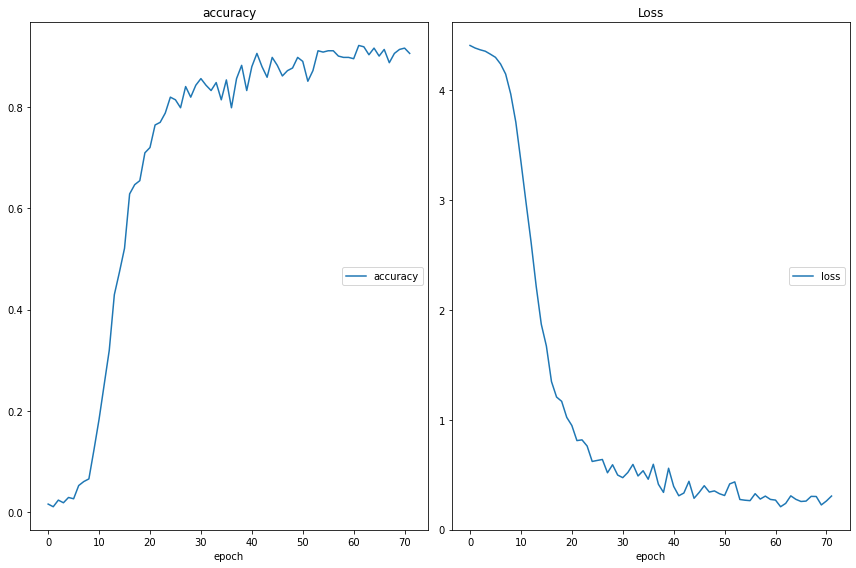

accuracy
	accuracy         	 (min:    0.010, max:    0.921, cur:    0.906)
Loss
	loss             	 (min:    0.208, max:    4.409, cur:    0.306)
####    New model trained and saved    ####


In [ ]:
train_model(model, X_train.toarray(), y_train, **TRAINING_PARAMS)  # train and save the model

### Tuning

## Chatbot

In [ ]:
class Chatbot:
    def __init__(self, vect_resp_path, model_path, pred_threshold):
        """Chatbot initialisation : loads vectorizers, model, responses and inits threshold
        args:
            vect_resp_path: str - Path of the vectorizers+responses object
            model_path: str - Path of the vectorizers+responses object
            pred_threshold: float - Predictions theshold
        """
        # loading fitted vectorizers and the responses
        self.vectorizer, self.label_binarizer, self.responses = joblib.load(vect_resp_path)
        # loading model
        self.model = load_model(model_path)
        # define threshold
        self.pred_threshold = pred_threshold
        print('#### Vectorizers, model and responses loaded ####')


    def predict_intents(self, input):
        """ Predict the label (intent) of a user input for a given model.
        inputs:
            input: str - user sentence
            model: obj - trained model to use for the prediction input
            kwargs: should contain the list of tokens in the corpus as :corpus_tokens: and the list of labels as :corpus_labels:
        output:
            return_list: list(dict) - contain the list of results sorted by probability
        """
        input_vect = self.vectorizer.transform([input])
        preds = self.model.predict(input_vect.toarray())[0]
        results = [[i, r] for i, r in enumerate(preds) if r > self.pred_threshold]
        if not results:
            return [{'intent': 'noanswer'}]
        # sorting strength probability
        results.sort(key=lambda x: x[1], reverse=True)
        return_list = []
        for r in results:
            return_list.append({"intent": self.label_binarizer.classes_[r[0]], "probability": str(r[1])})
        return return_list

    def get_response(self, intent):
        """ return a random response for a given intents
        inputs:
            ints: str - predicted intents of a user input
            data: dict - dataset containing the responses {intents:[{..., responses:["", ""]}]}
        output:
            result : str - The chatbot answers to display
        """
        resp = self.responses['responses'][self.responses['label'] == intent]
        result = random.choice(list(resp)[0])
        return result


In [ ]:
chatbot = Chatbot(PATHS['vectorizer-responses'], PATHS['model'], PRED_THRESHOLD)
print("\nBot : Hello, how can I help you ?")
while True:
    try:
        user_input = input("You : ")
        if user_input.lower() == "exit":
            print("Bot : Bye !")
            break
        predicted_intents = chatbot.predict_intents(user_input)
        res = chatbot.get_response(predicted_intents[0]['intent'])
        print("Bot :", res)
    # Press ctrl-c or ctrl-d on the keyboard to exitg
    except(KeyboardInterrupt, EOFError, SystemExit):
        break

#### Vectorizers, model and responses loaded ####

Bot : Hello, how can I help you ?
You : exit
Bot : Bye !
